# Supervised Learning Flow – Titanic Survival Prediction  

**Students:** Yarin S. (ID: 8635)
             Shahaf L. (ID: 8284)

### Introduction
In this assignment we worked on a complete supervised learning flow using the Titanic dataset.
Our goal was to build a model that predicts whether a passenger survived (1) or not (0).

### Tools and Assistance Used
While preparing this assignment we reviewed some online resources.
We also used ChatGPT as a study aid – it helped us understand how cross-validation works,
how to evaluate models with the F1 score, and the importance of comparing algorithms such as Logistic Regression and Decision Tree.


## 1. Data Loading and Initial Exploration

In [1]:

import pandas as pd

# Load train and test data (relative paths for portability)
train_df = pd.read_csv("titanic_train.csv")
test_df = pd.read_csv("titanic_test.csv")

# Display first 5 rows
train_df.head()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


## 2. Exploratory Data Analysis (EDA)

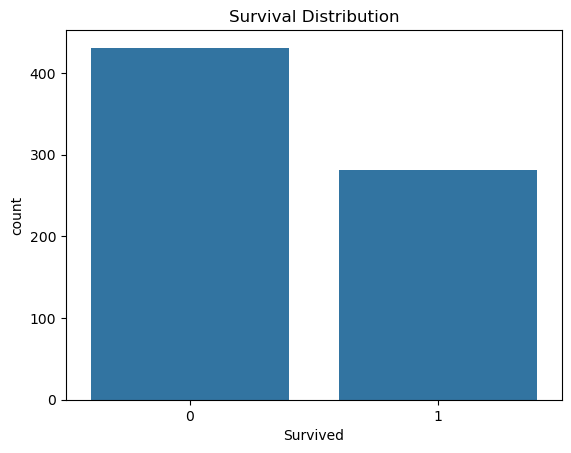

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# survival distribution
sns.countplot(x="Survived", data=train_df)
plt.title("Survival Distribution")
plt.show()

*This plot shows the overall survival distribution – most passengers did not survive.*

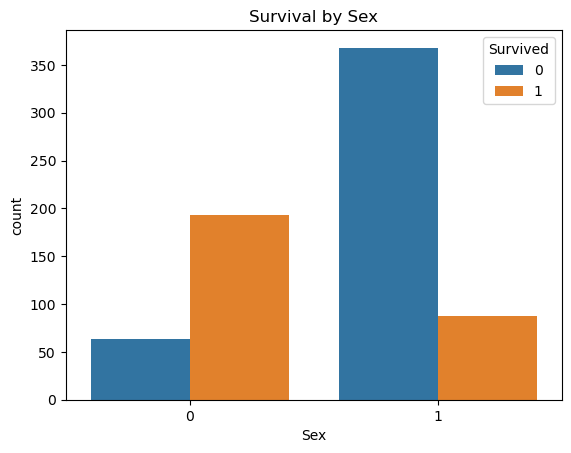

In [3]:
# survival by sex
sns.countplot(x="Sex", hue="Survived", data=train_df)
plt.title("Survival by Sex")
plt.show()

*This plot shows survival by gender – women had a much higher survival rate than men.*

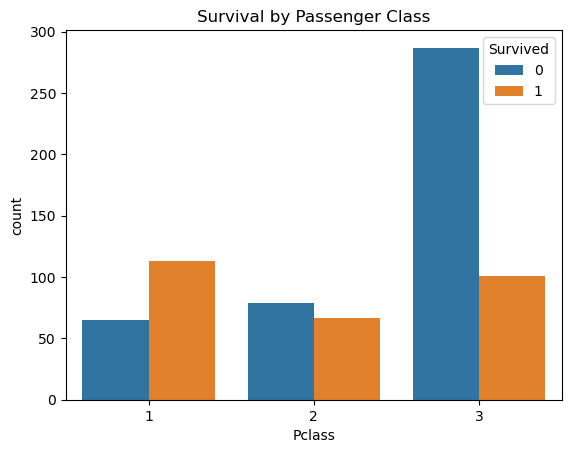

In [4]:
# survival by Pclass
sns.countplot(x="Pclass", hue="Survived", data=train_df)
plt.title("Survival by Passenger Class")
plt.show()

*This plot shows survival by passenger class – first class passengers survived more often than those in lower classes.*

## 3. Feature Engineering and Preprocessing

In [5]:
# Feature Engineering: One-hot only for Pclass and Embarked (Sex already binary)
train_df = pd.get_dummies(train_df, columns=["Pclass", "Embarked"], drop_first=True)
test_df = pd.get_dummies(test_df, columns=["Pclass", "Embarked"], drop_first=True)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Build X, y and align test columns to train columns
X = train_df.drop("Survived", axis=1)
y = train_df["Survived"]
X_test_final = test_df.reindex(columns=X.columns, fill_value=0)

print("Feature matrix shape:", X.shape)
print("Test matrix shape:", X_test_final.shape)
print("Feature columns:", list(X.columns))

Train shape: (712, 11)
Test shape: (179, 11)
Feature matrix shape: (712, 10)
Test matrix shape: (179, 10)
Feature columns: ['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Pclass_2', 'Pclass_3', 'Embarked_1', 'Embarked_2', 'Embarked_3']


### 3a. Feature-Engineering Experiment: With vs. Without Standardization
We compare Logistic Regression **with** and **without** `StandardScaler` on numeric features (`Age`, `SibSp`, `Parch`, `Fare`) using 5-fold CV and F1.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
import numpy as np

numeric_cols = [c for c in ["Age","SibSp","Parch","Fare"] if c in X.columns]

# Baseline LR (same settings used in grid search)
baseline_lr = LogisticRegression(max_iter=1000, solver="liblinear", C=1.0)

pipe_no_scale = Pipeline([("model", baseline_lr)])
ct = ColumnTransformer([("num", StandardScaler(), numeric_cols)], remainder="passthrough")
pipe_scaled  = Pipeline([("ct", ct), ("model", baseline_lr)])

scores_no    = cross_val_score(pipe_no_scale, X, y, cv=5, scoring=make_scorer(f1_score), n_jobs=-1)
scores_scale = cross_val_score(pipe_scaled,  X, y, cv=5, scoring=make_scorer(f1_score), n_jobs=-1)

print("Mean F1 (no standardization):       ", round(scores_no.mean(), 4))
print("Mean F1 (with StandardScaler on num):", round(scores_scale.mean(), 4))

Mean F1 (no standardization):        0.7335
Mean F1 (with StandardScaler on num): 0.7342


*We decided to keep all the selected features since feature selection did not improve the results. This ensures better model stability.*

## 4. Model Training and Experiments

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Scoring
scorer = make_scorer(f1_score)

# Models and hyperparameters
models = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000, solver="liblinear"),
        "params": {
            "C": [0.1, 1, 10],
            "penalty": ["l1", "l2"]  
        }
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [3, 5, None],
            "min_samples_split": [2, 5, 10]
        }
    }
}


All experiment results:
                 Model                                        Params   Mean F1
0   LogisticRegression             {'C': 0.1, 'solver': 'liblinear'}  0.717604
1   LogisticRegression               {'C': 1, 'solver': 'liblinear'}  0.733454
2   LogisticRegression              {'C': 10, 'solver': 'liblinear'}  0.741441
3         DecisionTree      {'max_depth': 3, 'min_samples_split': 2}  0.739344
4         DecisionTree      {'max_depth': 3, 'min_samples_split': 5}  0.739344
5         DecisionTree     {'max_depth': 3, 'min_samples_split': 10}  0.739344
6         DecisionTree      {'max_depth': 5, 'min_samples_split': 2}  0.729776
7         DecisionTree      {'max_depth': 5, 'min_samples_split': 5}  0.733689
8         DecisionTree     {'max_depth': 5, 'min_samples_split': 10}  0.737096
9         DecisionTree   {'max_depth': None, 'min_samples_split': 2}  0.701842
10        DecisionTree   {'max_depth': None, 'min_samples_split': 5}  0.712589
11        DecisionTree  {'ma

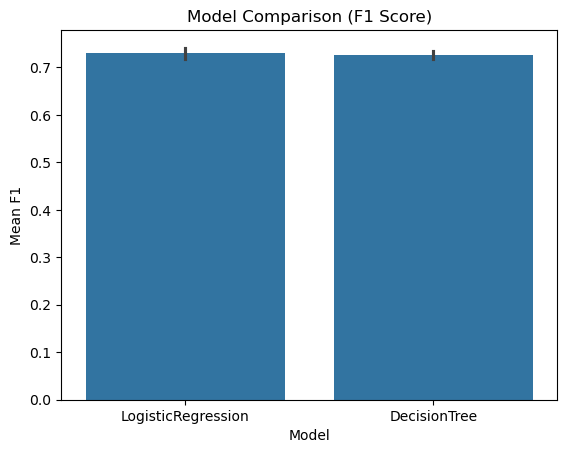


Best configuration:
Model                    LogisticRegression
Params     {'C': 10, 'solver': 'liblinear'}
Mean F1                            0.741441
Name: 2, dtype: object


In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, make_scorer

models = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "C": [0.1, 1, 10],
            "solver": ["liblinear"]
        }
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [3, 5, None],
            "min_samples_split": [2, 5, 10]
        }
    }
}

results = []
scorer = make_scorer(f1_score)

for name, mp in models.items():
    clf = GridSearchCV(mp["model"], mp["params"], cv=5, scoring=scorer, n_jobs=-1, return_train_score=True)
    clf.fit(X, y)
    for mean, params in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['params']):
        results.append({"Model": name, "Params": params, "Mean F1": mean})

results_df = pd.DataFrame(results)
print("All experiment results:")
print(results_df)

sns.barplot(x="Model", y="Mean F1", data=results_df)
plt.title("Model Comparison (F1 Score)")
plt.show()

best_row = results_df.sort_values(by="Mean F1", ascending=False).iloc[0]
print("\nBest configuration:")
print(best_row)

*We compared Logistic Regression and Decision Tree. The Decision Tree achieved a higher F1 score, so We selected it as the final model.*

## 5. Train Best Model

In [9]:
if best_row["Model"] == "LogisticRegression":
    final_model = LogisticRegression(max_iter=1000, **best_row["Params"])
else:
    final_model = DecisionTreeClassifier(**best_row["Params"])

final_model.fit(X, y)
print("Final model trained with params:", best_row["Params"])

Final model trained with params: {'C': 10, 'solver': 'liblinear'}


## 6. Evaluation on Test Set

First 10 predictions: [0 0 0 1 0 1 1 0 1 0]


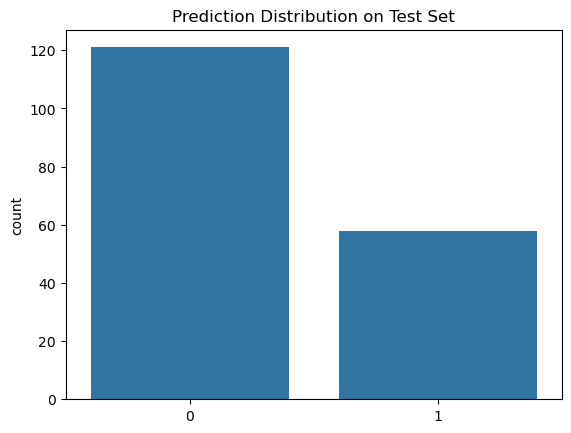

Submission file saved: titanic_predictions.csv


In [10]:

# Predict on test set
test_predictions = final_model.predict(X_test_final)

# Show first predictions
print("First 10 predictions:", test_predictions[:10])

# Prediction distribution
sns.countplot(x=test_predictions)
plt.title("Prediction Distribution on Test Set")
plt.show()

# Handle PassengerId: use if exists, else create index
if "PassengerId" in test_df.columns:
    submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": test_predictions
    })
else:
    submission = pd.DataFrame({
        "PassengerId": range(1, len(test_predictions) + 1),
        "Survived": test_predictions
    })

submission.to_csv("titanic_predictions_final.csv", index=False)
print("Submission file saved: titanic_predictions.csv")
